In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/processed.csv')

# Parse dates if necessary and ensure the 'Date' column is of the datetime type
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


In [7]:
# Check for any missing values in the dataset
missing_values = data.isnull().sum()

# Show the result of missing values check and the first few rows to verify the changes
missing_values_summary = missing_values[missing_values > 0]
data_head = data.head()

missing_values_summary, data_head


(Series([], dtype: int64),
             TotalRevenue  OperatingRevenue  CostOfRevenue  GrossProfit  \
 Date                                                                     
 1985-09-30     590500000         590500000     1062860000    498930000   
 1985-12-31     504200000         504200000     1044910000    550740000   
 1986-03-31     592400000         592400000     1044910000    550740000   
 1986-06-30     647900000         647900000     1044910000    550740000   
 1986-09-30     726400000         726400000     1062860000    498930000   
 
             OperatingExpense  OperatingIncome  OtherIncomeExpense  \
 Date                                                                
 1985-09-30         211100000      -1063400000            22540000   
 1985-12-31         248690000        504200000             3930000   
 1986-03-31         248690000        592400000             3930000   
 1986-06-30         248690000        647900000             3930000   
 1986-09-30         211100

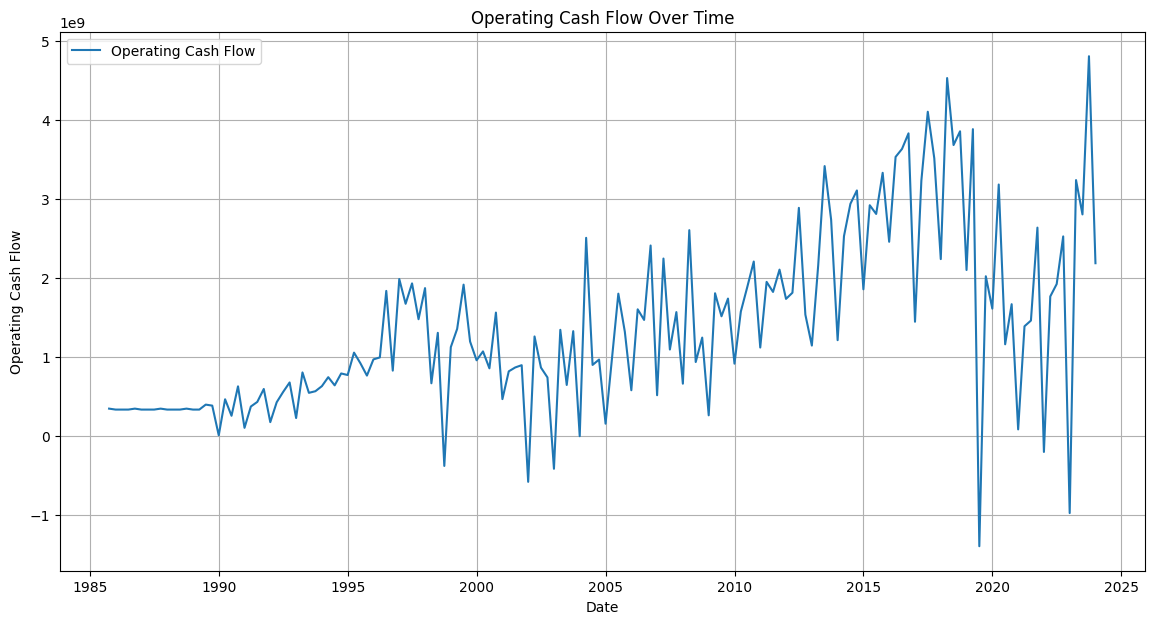

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the column name for Operating Cash Flow based on typical financial reporting terms
# (Assuming it is labeled clearly, we will look for a likely match. Adjust the name as needed.)
operating_cash_flow_col = 'OperatingCashFlow'  # Change if different

# Plot Operating Cash Flow
plt.figure(figsize=(14, 7))
plt.plot(data.index, data[operating_cash_flow_col], label='Operating Cash Flow')
plt.title('Operating Cash Flow Over Time')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

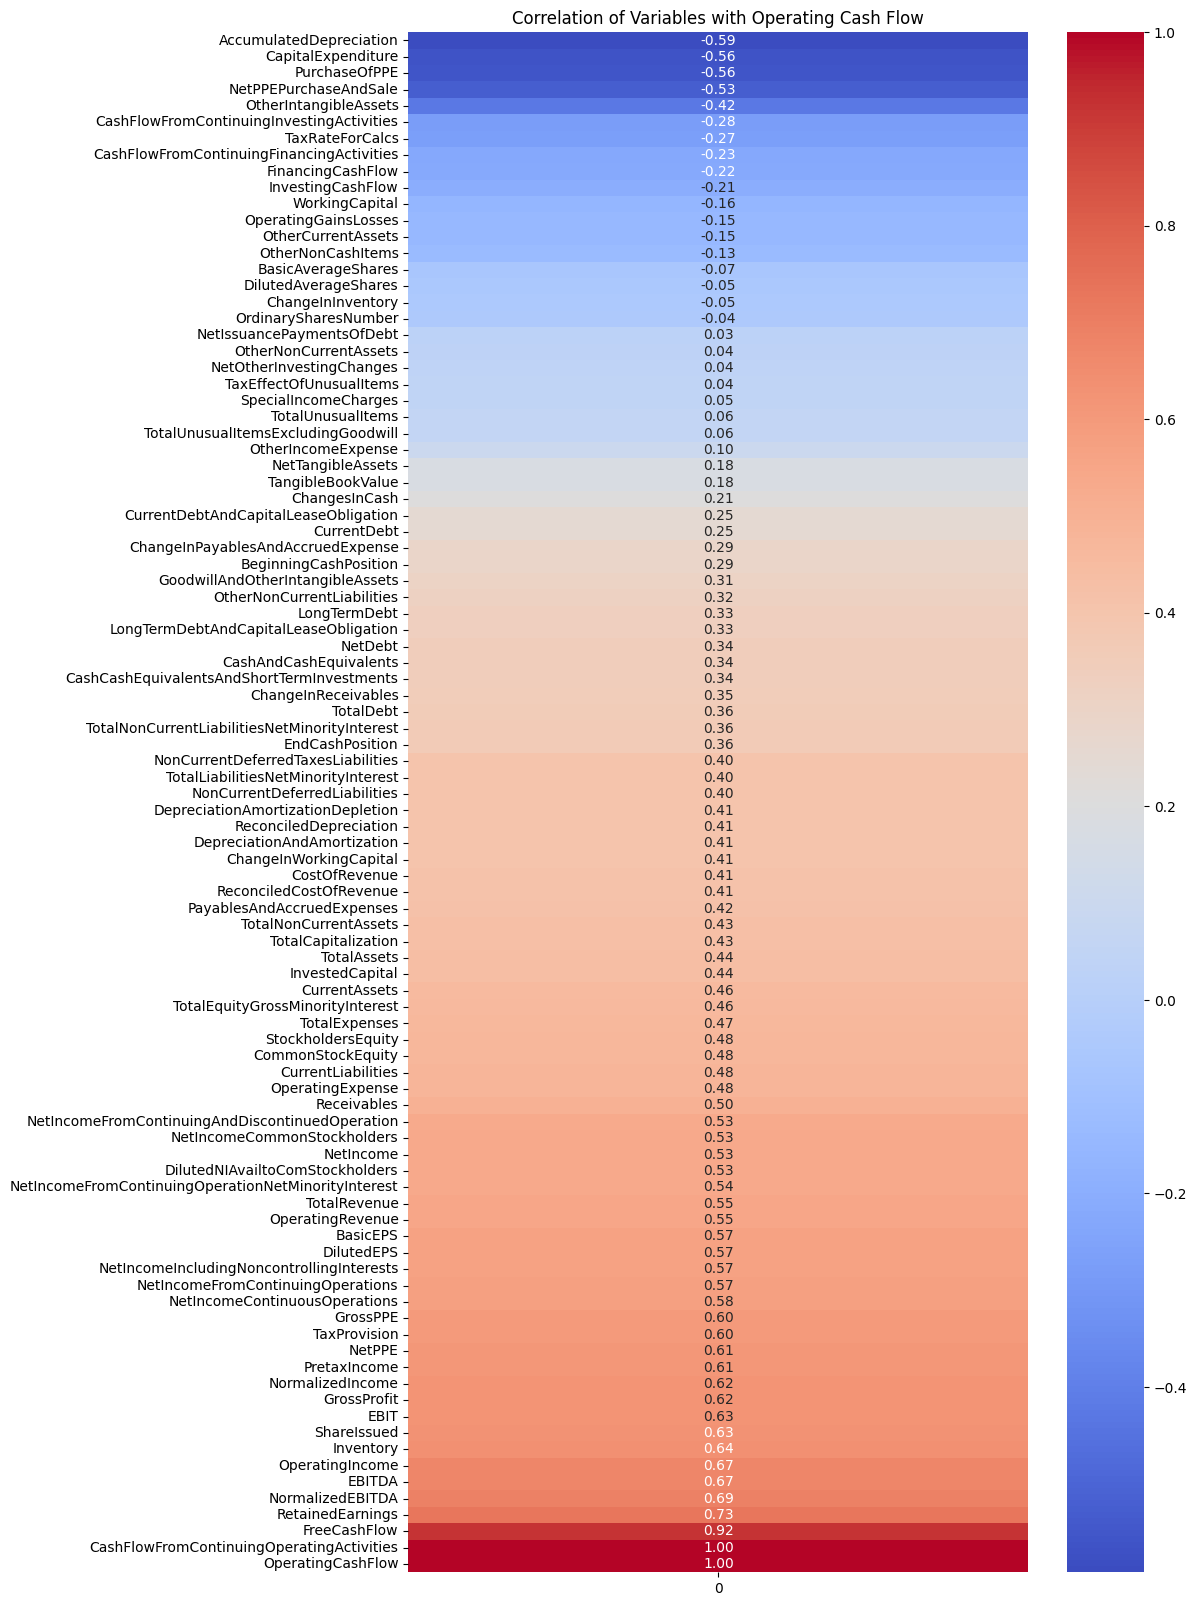

In [12]:
# Recompute correlation of Operating Cash Flow with other variables using the correct column
correlation = data.corr()[operating_cash_flow_col].sort_values()

# Fix the heatmap plot issue by converting to a numpy array
plt.figure(figsize=(10, 20))
sns.heatmap(correlation.values[:, None], annot=True, fmt=".2f", cmap='coolwarm', cbar=True,
            yticklabels=correlation.index)
plt.title('Correlation of Variables with Operating Cash Flow')
plt.show()

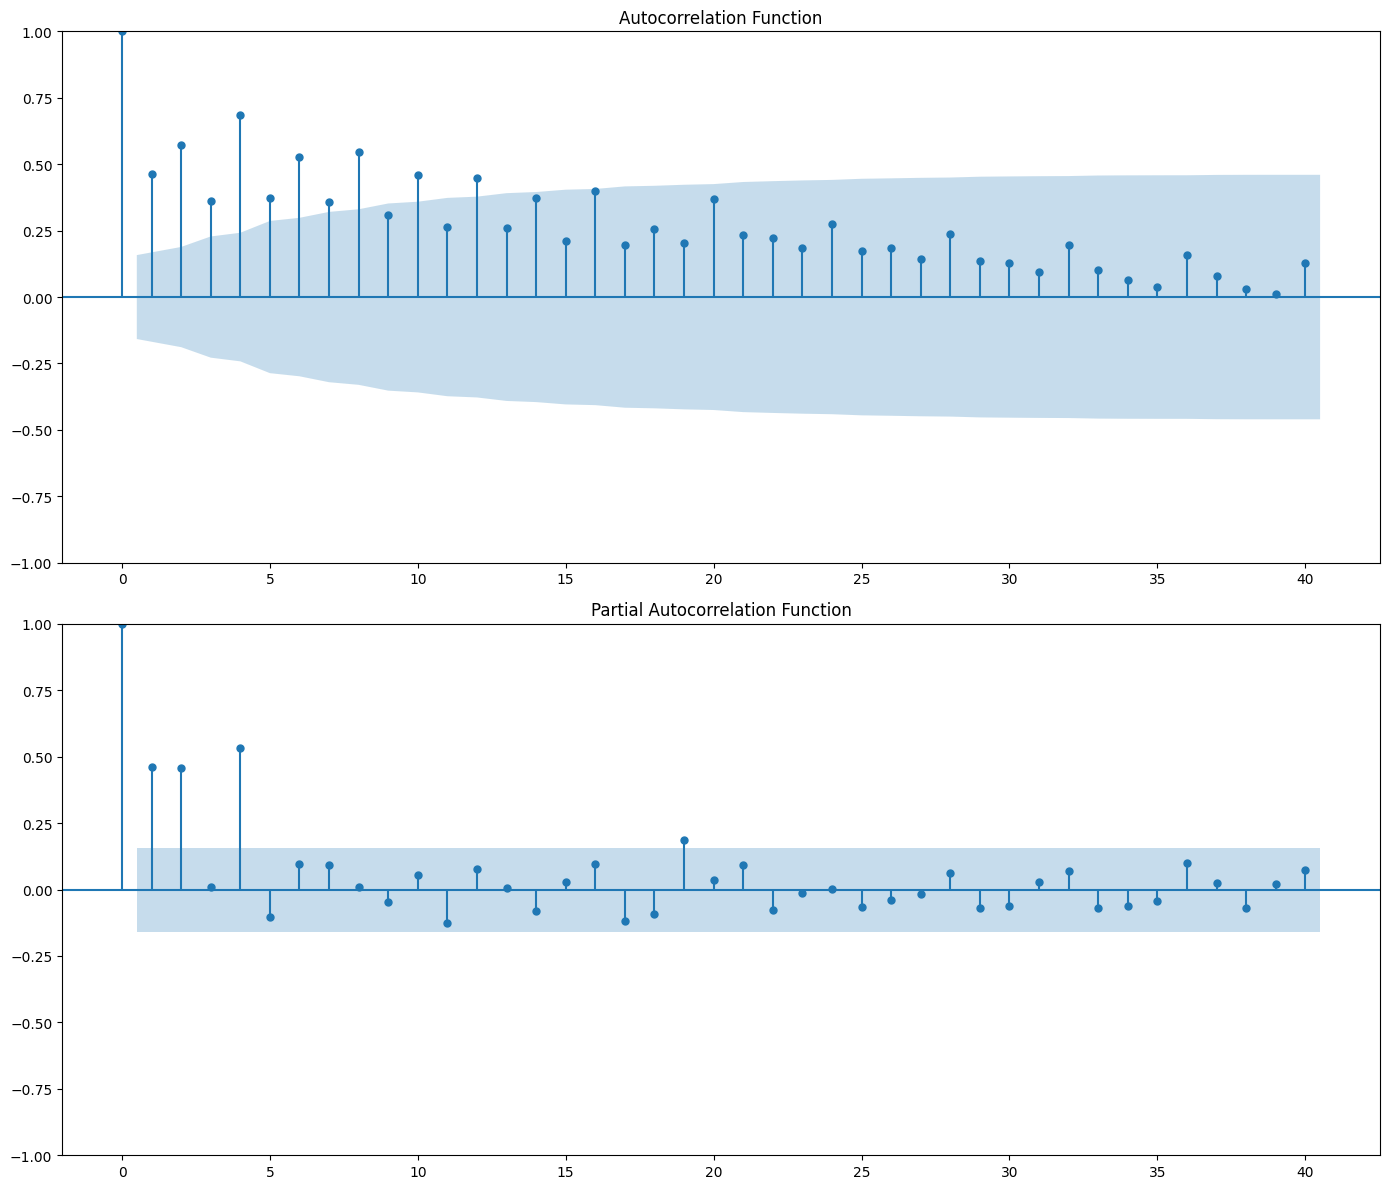

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate ACF and PACF plots for Operating Cash Flow
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Autocorrelation plot
plot_acf(data[operating_cash_flow_col], lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

# Partial Autocorrelation plot
plot_pacf(data[operating_cash_flow_col], lags=40, ax=ax2, method='ywm')
ax2.set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Configure and fit the SARIMAX model on the training data
model = SARIMAX(train[operating_cash_flow_col], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Summary of the model fit
model_summary = model_fit.summary()
model_summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      OperatingCashFlow   No. Observations:                  123
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2632.888
Date:                Fri, 12 Apr 2024   AIC                           5271.776
Time:                        04:20:13   BIC                           5280.188
Sample:                    09-30-1985   HQIC                          5275.193
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2658      0.126     -2.112      0.035      -0.513      -0.019
ma.L1         -0.7213      0.087     -8.316      0.000      -0.891      -0.551
sigma2      3.749e+17   8.41e-21   4.46e+37      0.000    3.75e+17    3.75e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                10.84
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              18.16   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+54. Standard errors may be unstable.
"""

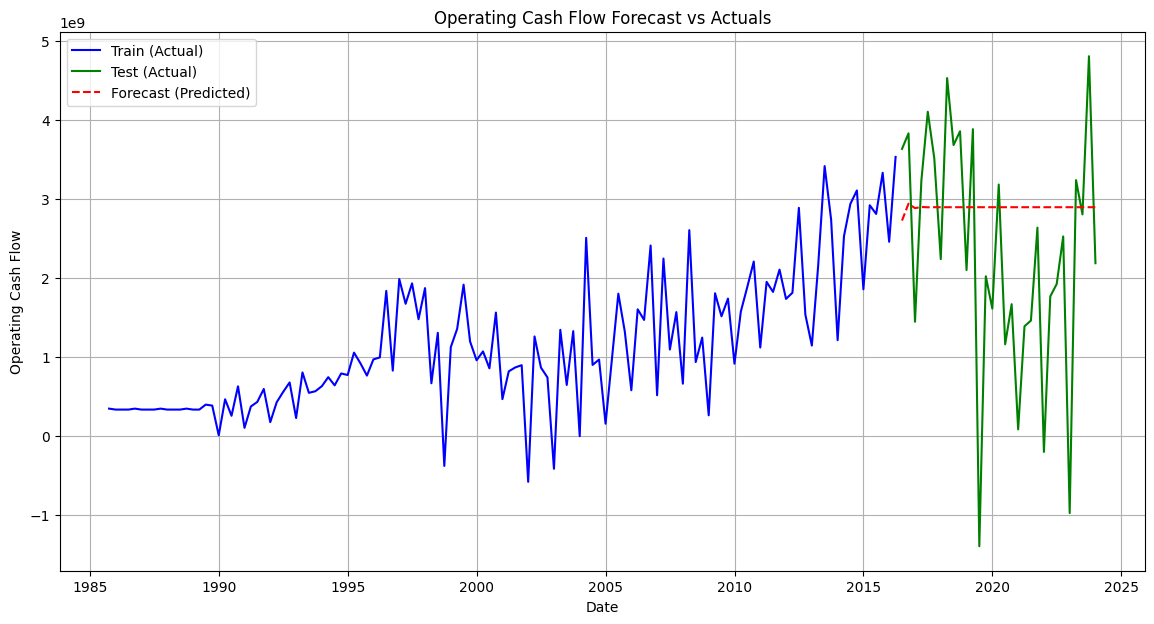

1613022250.73292

In [15]:
from statsmodels.tools.eval_measures import rmse

# Forecast the test set
forecast = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

# Calculate RMSE
forecast_rmse = rmse(test[operating_cash_flow_col], forecast_mean)

# Plot actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[operating_cash_flow_col], label='Train (Actual)', color='blue')
plt.plot(test.index, test[operating_cash_flow_col], label='Test (Actual)', color='green')
plt.plot(test.index, forecast_mean, label='Forecast (Predicted)', color='red', linestyle='--')
plt.title('Operating Cash Flow Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

forecast_rmse

In [16]:
# Identify top correlated variables with Operating Cash Flow, excluding itself
top_exogenous = data.corr()[operating_cash_flow_col].sort_values(ascending=False).drop(operating_cash_flow_col).head(5).index.tolist()

# Prepare exogenous variables
exog_data = data[top_exogenous]

# Split exogenous data into training and testing sets corresponding to the main train/test split
exog_train, exog_test = exog_data[:train_size], exog_data[train_size:]

# Reconfigure and fit the SARIMAX model with exogenous variables
model_with_exog = SARIMAX(train[operating_cash_flow_col], exog=exog_train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_with_exog_fit = model_with_exog.fit(disp=False)

# Summary of the new model fit
model_with_exog_summary = model_with_exog_fit.summary()
model_with_exog_summary


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      OperatingCashFlow   No. Observations:                  123
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1986.968
Date:                Fri, 12 Apr 2024   AIC                           3989.937
Time:                        04:34:38   BIC                           4012.369
Sample:                    09-30-1985   HQIC                          3999.048
                         - 03-31-2016                                         
Covariance Type:                  opg                                         
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
CashFlowFromContinuingOperatingActivities     0.9998      0.003    290.677      0.000       0.993       1.007
FreeCashFlow                                  0.0009      0.002      0.376      0.707      -0.004       0.006
RetainedEarnings                          -2.741e-05      0.000     -0.097      0.923      -0.001       0.001
NormalizedEBITDA                             -0.0025      0.001     -1.746      0.081      -0.005       0.000
EBITDA                                        0.0024      0.003      0.892      0.372      -0.003       0.008
ar.L1                                        -0.5105      0.049    -10.354      0.000      -0.607      -0.414
ma.L1                                        -0.7757      0.092     -8.465      0.000      -0.955      -0.596
sigma2                                     1.131e+13    5.3e-15   2.13e+27      0.000    1.13e+13    1.13e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):              4645.32
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):             394.24   Skew:                             3.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.14e+42. Standard errors may be unstable.
"""

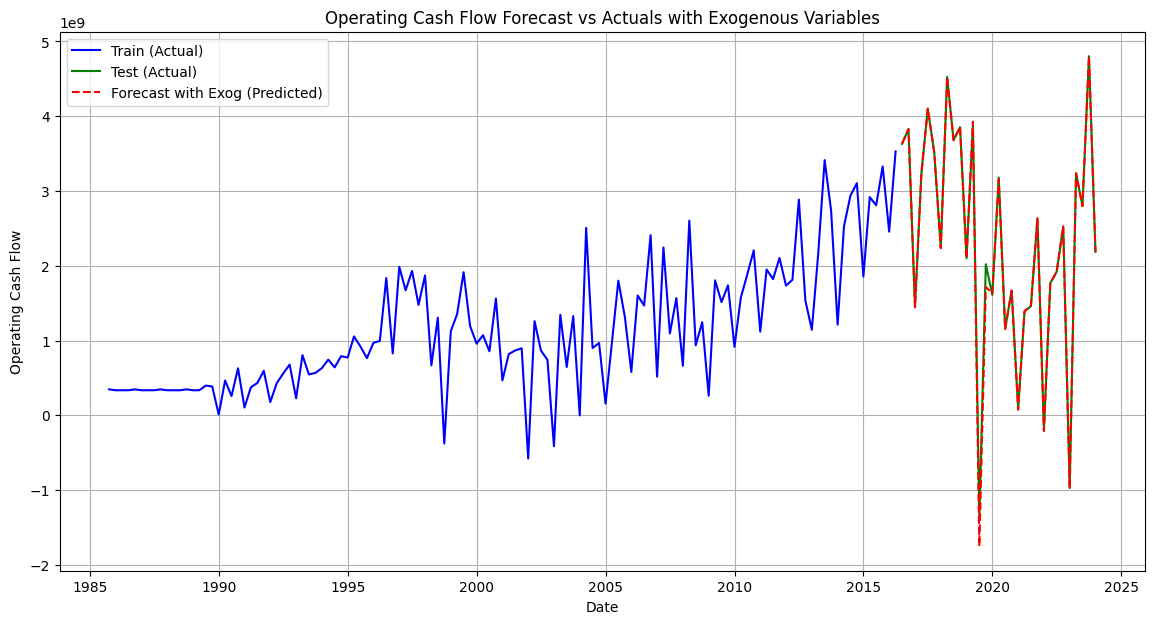

85056627.35113262

In [20]:
# Forecast the test set with the updated model including exogenous variables
forecast_with_exog = model_with_exog_fit.get_forecast(steps=len(test), exog=exog_test)
forecast_with_exog_mean = forecast_with_exog.predicted_mean

# Calculate RMSE for the new forecast
forecast_with_exog_rmse = rmse(test[operating_cash_flow_col], forecast_with_exog_mean)

# Plot actual vs predicted values with exogenous variables included
plt.figure(figsize=(14, 7))
plt.plot(train.index, train[operating_cash_flow_col], label='Train (Actual)', color='blue')
plt.plot(test.index, test[operating_cash_flow_col], label='Test (Actual)', color='green')
plt.plot(test.index, forecast_with_exog_mean, label='Forecast with Exog (Predicted)', color='red', linestyle='--')
plt.title('Operating Cash Flow Forecast vs Actuals with Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('Operating Cash Flow')
plt.legend()
plt.grid(True)
plt.show()

forecast_with_exog_rmse


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test[operating_cash_flow_col], forecast_with_exog_mean)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((test[operating_cash_flow_col] - forecast_with_exog_mean) / test[operating_cash_flow_col])) * 100

mae, mape


(26264448.03630244, 2.051902252729053)

In [34]:
# Combine actual and predicted values into a DataFrame
comparison_df = pd.DataFrame({
    'Actual': test[operating_cash_flow_col],
    'Predicted': forecast_with_exog_mean.round(0).astype(int)  # Rounding predicted values to the nearest integer
})

# Print the DataFrame to see the actual and predicted values side by side in the same format
print(comparison_df)


                Actual   Predicted
2016-06-30  3630000000  3630458731
2016-09-30  3827000000  3827495583
2016-12-31  1445000000  1443862713
2017-03-31  3228000000  3228164638
2017-06-30  4100000000  4100900728
2017-09-30  3512000000  3512408459
2017-12-31  2237000000  2236161509
2018-03-31  4526000000  4526763301
2018-06-30  3679000000  3678893487
2018-09-30  3853000000  3854576012
2018-12-31  2099000000  2097698019
2019-03-31  3880000000  3926500551
2019-06-30 -1393000000 -1751356050
2019-09-30  2020000000  1715937598
2019-12-31  1611000000  1628974184
2020-03-31  3180000000  3157453274
2020-06-30  1160000000  1151003709
2020-09-30  1667000000  1668224246
2020-12-31    84000000    73994135
2021-03-31  1388000000  1392746989
2021-06-30  1460000000  1465616135
2021-09-30  2635000000  2632497548
2021-12-31  -201000000  -211551573
2022-03-31  1765000000  1764077264
2022-06-30  1922000000  1920845450
2022-09-30  2524000000  2524682343
2022-12-31  -974000000  -976687723
2023-03-31  32360000

# LSTM

In [25]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

# Assuming 'data' is the original DataFrame and has been preprocessed similarly to previous steps
data_series = data['OperatingCashFlow'].values.reshape(-1, 1)  # Reshape for compatibility with MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_series)

# Define sequence length (number of time steps to look back for predicting the next value)
sequence_length = 4

# Prepare data generators for training and testing
train_data_gen = TimeseriesGenerator(scaled_data[:train_size], scaled_data[:train_size],
                                     length=sequence_length, batch_size=1)
test_data_gen = TimeseriesGenerator(scaled_data[train_size:], scaled_data[train_size:],
                                    length=sequence_length, batch_size=1)
# Check the shape of generated data samples
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print('Input data shape:', x.shape, 'Output data shape:', y.shape)
    if i == 0:  # Just display the first batch shapes
        break


Input data shape: (1, 4, 1) Output data shape: (1, 1)


In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
# Train the model
model.fit(train_data_gen, epochs=20, verbose=1)


Epoch 1/20
119/119 [==============================] - 4s 8ms/step - loss: 0.0227
Epoch 2/20
119/119 [==============================] - 1s 7ms/step - loss: 0.0100
Epoch 3/20
119/119 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 4/20
119/119 [==============================] - 1s 7ms/step - loss: 0.0089
Epoch 5/20
119/119 [==============================] - 1s 4ms/step - loss: 0.0088
Epoch 6/20
119/119 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 7/20
119/119 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 8/20
119/119 [==============================] - 0s 3ms/step - loss: 0.0078
Epoch 9/20
119/119 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 10/20
119/119 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 11/20
119/119 [==============================] - 0s 3ms/step - loss: 0.0081
Epoch 12/20
119/119 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 13/20
119/119 [====

In [28]:
# Predict using the test data generator
predictions = model.predict(test_data_gen)

# Invert scaling for actual comparison
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(scaled_data[train_size + sequence_length:])

# Calculate RMSE or other performance metrics
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE:', rmse)


27/27 [==============================] - 1s 4ms/step
Test RMSE: 1484387355.3817458


In [23]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Extend the dataset to include the future quarter (March 2024) for forecasting
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=1, freq='Q')
future_df = pd.DataFrame(index=future_dates, columns=data.columns)
extended_data = pd.concat([data, future_df])

# Forward fill the exogenous variables to cover all dates including the extended future dates
extended_exog = extended_data[['Exog1', 'Exog2', 'Exog3']]  # Replace with actual names of exogenous variables
extended_exog_ffill = extended_exog.ffill()

# Convert all columns to numeric, assuming that they should be numeric for SARIMAX
extended_data_numeric = extended_data.apply(pd.to_numeric, errors='coerce')
extended_exog_numeric = extended_exog_ffill.apply(pd.to_numeric, errors='coerce')

# Fit the SARIMAX model with numeric and aligned data
model = SARIMAX(extended_data_numeric['OperatingCashFlow'], exog=extended_exog_numeric,
                order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Forecast including the test period and the March 2024 quarter
forecast = model_fit.get_forecast(steps=len(test) + 1, exog=extended_exog_numeric[-(len(test)+1):])
forecast_mean = forecast.predicted_mean

# Display the forecasted values
forecast_mean

KeyError: "None of [Index(['Exog1', 'Exog2', 'Exog3'], dtype='object')] are in the [columns]"

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_test_op = adfuller(data['OperatingCashFlow'])
adf_test_free = adfuller(data['FreeCashFlow'])

print(f'ADF Statistic for Operating Cash Flow: {adf_test_op[0]}')
print(f'ADF Statistic for Free Cash Flow: {adf_test_free[0]}')


ADF Statistic for Operating Cash Flow: -1.489410119940658
ADF Statistic for Free Cash Flow: -2.474550117741056


In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# I'll assume your data is loaded into a pandas DataFrame with a column named 'OperatingCashFlow'
# that contains the time series data. The DataFrame index should be a DatetimeIndex.

# Function to perform the Augmented Dickey-Fuller test
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')  # AIC will choose the best lag for us
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')

# Perform ADF test on the original data
print('Results of Dickey-Fuller Test on Original Data:')
adf_test(data['OperatingCashFlow'])

# Differencing the time series
data_diff = data['OperatingCashFlow'].diff().dropna()  # First difference to remove trend

# Perform ADF test on the differenced data
print('\nResults of Dickey-Fuller Test on Differenced Data:')
adf_test(data_diff)

Results of Dickey-Fuller Test on Original Data:


NameError: name 'data' is not defined

#Thus we can conclude that Time series is one time differencing

In [ ]:
# Define the training and testing dataset. Usually, the last part is for testing.
train_op = data['OperatingCashFlow_diff'][:-4] # last 4 quarters for testing
test_op = data['OperatingCashFlow_diff'][-4:]

train_free = data['FreeCashFlow_diff'][:-4]
test_free = data['FreeCashFlow_diff'][-4:]


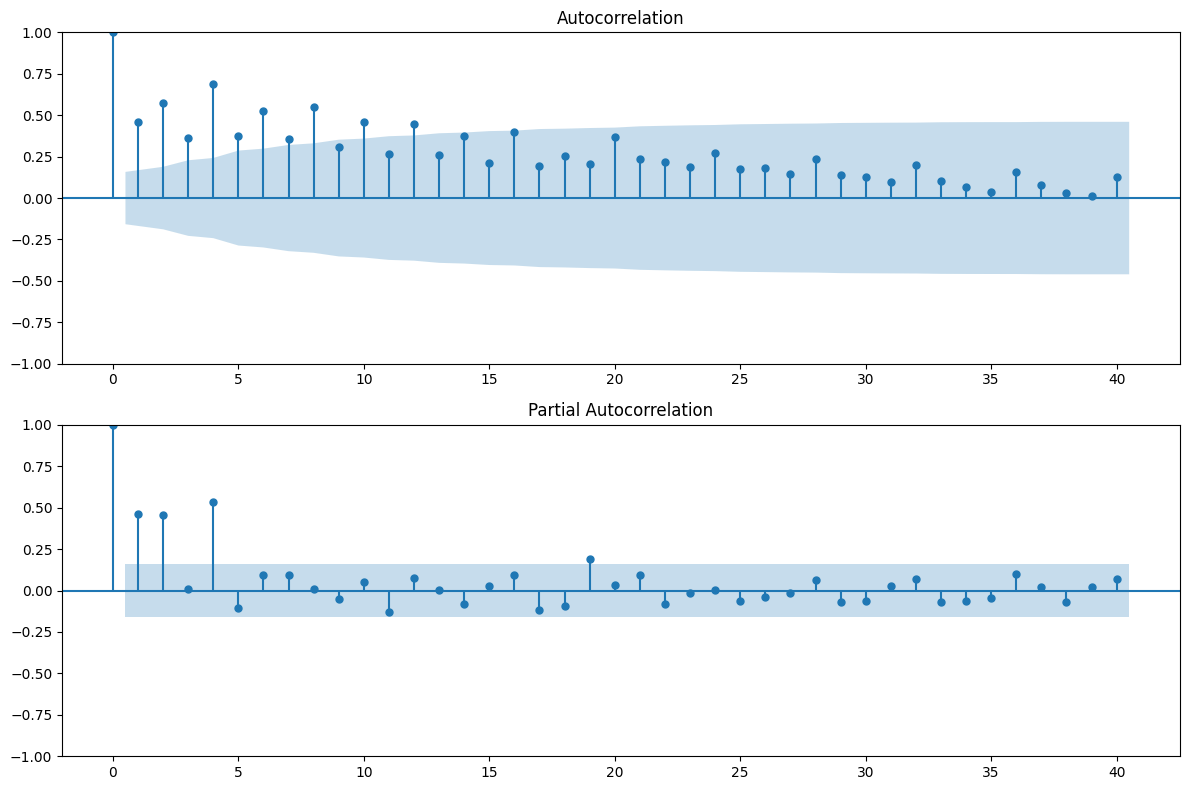

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'data' is your DataFrame containing the 'OperatingCashFlow' column

# Plot ACF and PACF for 'OperatingCashFlow'
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the Autocorrelation Function (ACF)
plot_acf(data['OperatingCashFlow'], lags=40, ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(data['OperatingCashFlow'], lags=40, ax=ax2)

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
# ARIMA is a common choice, but you might also explore SARIMA, SARIMAX, LSTM, or Prophet
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
# Fit ARIMA model. Note: You'll need to choose the order (p, d, q) based on ACF and PACF plots or grid search
model_op = ARIMA(train_op, order=(1,1,1))
results_op = model_op.fit()

model_free = ARIMA(train_free, order=(1,1,1))
results_free = model_free.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  

In [ ]:
# Predict the next 2 quarters
predictions_op = results_op.forecast(steps=4)
predictions_free = results_free.forecast(steps=4)

In [ ]:
# To revert differencing, add the predictions to the last known value
last_value_op = data['OperatingCashFlow'].iloc[-5]
predictions_op_cumsum = predictions_op.cumsum()
predicted_op = predictions_op_cumsum + last_value_op

last_value_free = data['FreeCashFlow'].iloc[-5]
predictions_free_cumsum = predictions_free.cumsum()
predicted_free = predictions_free_cumsum + last_value_free

In [ ]:
# Evaluate the model using RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_op = sqrt(mean_squared_error(test_op, predictions_op))
rmse_free = sqrt(mean_squared_error(test_free, predictions_free))

print(f'RMSE for Operating Cash Flow: {rmse_op}')
print(f'RMSE for Free Cash Flow: {rmse_free}')

RMSE for Operating Cash Flow: 1647283257.3912642
RMSE for Free Cash Flow: 1615451400.662893


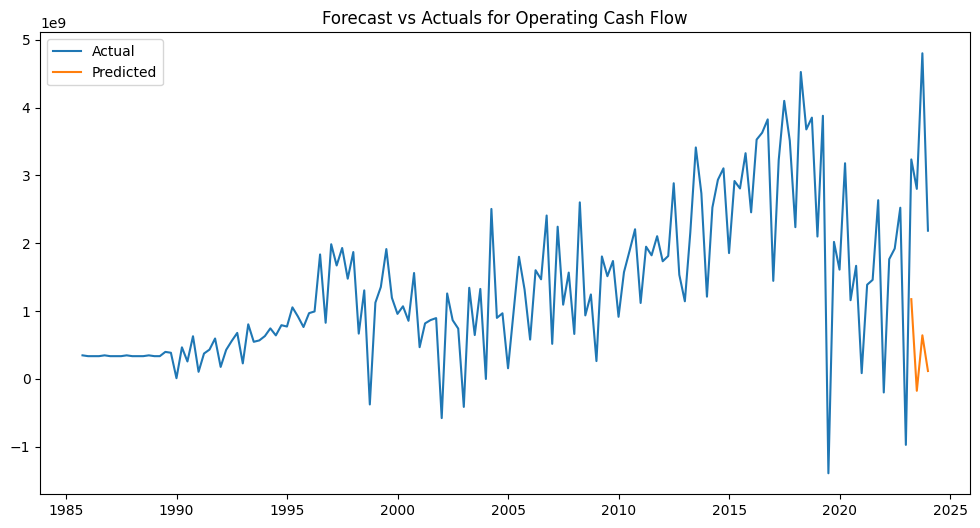

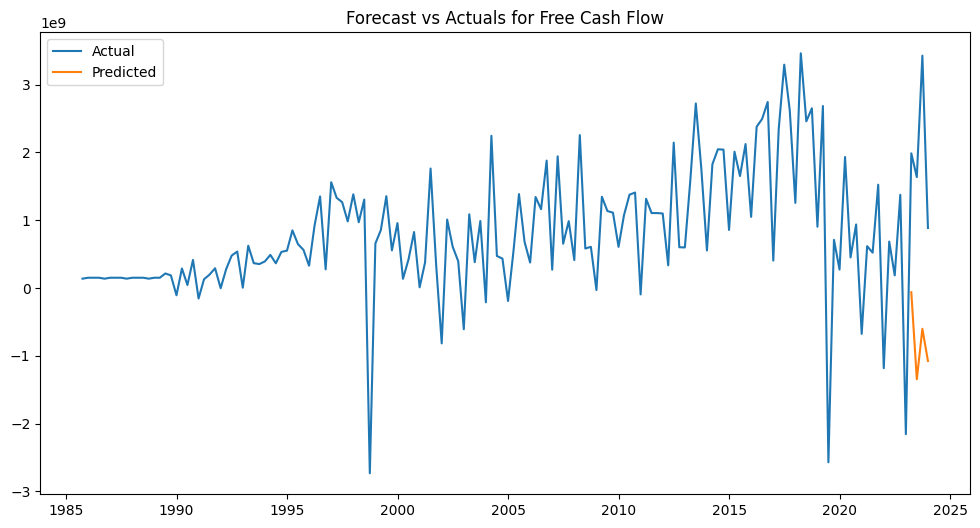

In [ ]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12,6))
plt.plot(data['OperatingCashFlow'], label='Actual')
plt.plot(predicted_op, label='Predicted')
plt.legend()
plt.title('Forecast vs Actuals for Operating Cash Flow')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(data['FreeCashFlow'], label='Actual')
plt.plot(predicted_free, label='Predicted')
plt.legend()
plt.title('Forecast vs Actuals for Free Cash Flow')
plt.show()